**Exercice Ré-identification**

Dans cet exercice, on cherche à entraîner un réseau sur une tâche de ré-identification. On travaille ici avec un nombre restreint d'images réelles, provenant de caméras fixes différentes. Pour chaque caméra on dispose de dix images prises sous des météorologie/conditions d'éclairage différentes.

Comme le jeu est de petite taille, on peut se permettre de le charger entièrement sur une carte GPU. C'est l'objet des cellules de codes qui suivent les imports:

In [9]:
import torch
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader,TensorDataset
from torch import randint
import os
from os.path import join
ls = lambda rep: sorted(os.listdir(rep))
import matplotlib.pyplot as plt
import torch
from torchvision import datasets, models, transforms, utils
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms.functional as TF
import random
import numpy as np
import os
import time

In [10]:
# Liens valable jusqu'au 17/01/2024:
# data à charger:
! wget https://www.grosfichiers.com/L7R8MLxtfzG_NwC5CzNnTSt
! tar xvf L7R8MLxtfzG_NwC5CzNnTSt
! rm L7R8MLxtfzG_NwC5CzNnTSt
# module à charger
! wget https://www.grosfichiers.com/HAnmgiuVNGn_XtdcYCeMNnJ
! mv HAnmgiuVNGn_XtdcYCeMNnJ utile_BE.py
from utile_BE import *

--2024-01-11 22:58:19--  https://www.grosfichiers.com/L7R8MLxtfzG_NwC5CzNnTSt
Resolving www.grosfichiers.com (www.grosfichiers.com)... 51.68.254.173
Connecting to www.grosfichiers.com (www.grosfichiers.com)|51.68.254.173|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1679779840 (1.6G) [application/x-tar]
Saving to: ‘L7R8MLxtfzG_NwC5CzNnTSt’

L7R8MLxtfzG_NwC5CzN 100%[===================>]   1.56G  29.8MB/s    in 54s     

2024-01-11 22:59:14 (29.4 MB/s) - ‘L7R8MLxtfzG_NwC5CzNnTSt’ saved [1679779840/1679779840]

data/
data/donut_unet_300ep_step1.pt
data/netG_180ep_WGP_scheduler75_lr005.pt
data/reid_resnet50_60ep.pt
data/tensor_test.pt
data/tensor_test_cpu.pt
data/tensor_train.pt
data/tensor_val.pt
--2024-01-11 22:59:22--  https://www.grosfichiers.com/HAnmgiuVNGn_XtdcYCeMNnJ
Resolving www.grosfichiers.com (www.grosfichiers.com)... 51.68.254.173
Connecting to www.grosfichiers.com (www.grosfichiers.com)|51.68.254.173|:443... connected.
HTTP request sent, awaiting 

**Q1** Quelle sont les dimensions du tenseur contenu dans 'data/tensor_train.pt' ? A quoi ces dimensions correspondent-elles ?  

In [12]:
# Les images sont empilées dans les .pt:
tensor_train = torch.load('data/tensor_train.pt')
print(tensor_train.shape)
# 5000 images d'entraînement RGB (3 canaux) de dimension 128 x 128

torch.Size([5000, 3, 128, 128])


**Q2** Passer les trois tenseurs issus des .pt sur carte GPU. Les stocker dans le dictionnaire ds_tensor:

In [13]:
ds_tensor = {}
# Les images sont empilées dans les .pt:
ds_tensor['train'] = tensor_train.cuda()
tensor_val = torch.load('data/tensor_val.pt')
ds_tensor['val'] = tensor_val.cuda()
tensor_test = torch.load('data/tensor_test.pt')
ds_tensor['test'] = tensor_test.cuda()

**Q3** Pour entraîner le réseau, on utilise les transformations de données définies dans la cellule suivante. Quels sont les rôles de self.rotate et TF.hflip dans *tr_triplet*?

In [14]:
# Les transformations de données:

class tr_triplet:

    def __init__(self, marginsup, margininf, cropped_prop, size_in, size_out, zoom =20,
                 rotation = False, angle_max= 5, perspective = False, ph = 0.2, pv = 0.05,  colorjitter=False, fixed_top = False, **kwargs):
        self.marginsup = marginsup
        self.margininf = margininf
        self.size_out = size_out
        self.size_in = size_in
        self.ysup = round(self.marginsup * self.size_in)
        self.yinf = round(self.margininf * self.size_in)
        self.fixed_top = False
        self.cropped_prop = cropped_prop
        self.zoom = zoom
        self.rotation = rotation
        self.angle_max = angle_max
        self.colorjitter = colorjitter
        self.perspective = perspective
        self.pv = pv
        self.ph = ph


        if self.colorjitter:
            self.cj = transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.1, hue=0.1)

        self.rs_out = transforms.Resize(size_out)

    def __call__(self, imgs):

        if self.rotation:
            angle = torch.randint(-self.angle_max, self.angle_max, (1,)).item()

        reduc = torch.randint(0,self.zoom,(1,)).item()/100

        size_crop = round((1-reduc)*self.cropped_prop*self.size_in)

        top = torch.randint(self.ysup,
                            self.size_in - size_crop - self.yinf,(1,)).item()
        if self.fixed_top:
            top = self.ysup

        left = torch.randint(0, self.size_in - size_crop,(1,)).item()
        tr_imgs = []

        if self.perspective:

            htl = ( - self.ph*torch.rand(1).item())* self.size_in
            vtl = ( - self.pv*torch.rand(1).item())* self.size_in

            htr = (1+ self.ph* torch.rand(1).item())* self.size_in
            vtr = ( - self.pv* torch.rand(1).item())* self.size_in

            hbr = (1 + self.ph* torch.rand(1).item())* self.size_in
            vbr = (1 + self.pv* torch.rand(1).item())* self.size_in

            hbl = ( - self.ph* torch.rand(1).item())* self.size_in
            vbl = (1 + self.pv*torch.rand(1).item())* self.size_in

            startpoints =  [(0.,0.), (self.size_in,0.), (self.size_in,self.size_in),(0.,self.size_in)]
            endpoints = [( htl , vtl ), ( htr , vtr), ( hbr , vbr ),( hbl , vbl )]

        flip = torch.randint(0,2, (1,)).item()


        for img in imgs:

            if self.rotation:
                img = TF.rotate(img, angle)

            if self.perspective:
                img =  TF.perspective(img,  startpoints, endpoints)

            img = TF.crop(img,top,left,size_crop,size_crop)

            if self.colorjitter:
                img = self.cj(img)

            img = self.rs_out(img)

            if flip == 1:
                img = TF.hflip(img)

            img = transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])(img)
            tr_imgs.append(img)

        return tr_imgs


class Simple_crop_norsin:

    def __init__(self, marginsup, margininf, cropped_prop, size_in, size_out, **kwargs):
        self.marginsup = marginsup
        self.margininf = margininf
        self.size_out = size_out

        self.size_in = size_in

        self.ysup = round(self.marginsup * self.size_in)
        self.yinf = round(self.margininf * self.size_in)

        self.cropped_prop = cropped_prop
        self.rs_out = transforms.Resize(size_out)


    def __call__(self, imgs):

        size_crop = round(self.cropped_prop * self.size_in)
        top = round(self.ysup)
        left = round(0.5*(self.size_in - size_crop))

        tr_imgs = []
        for img in imgs:
            img = TF.crop(img,top,left,size_crop,size_crop)
            img = self.rs_out(img)
            img = transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])(img)

            tr_imgs.append(img)

        return tr_imgs

In [27]:
class DS_triplet_flat_pt(torch.utils.data.Dataset):

    def __init__(self, dataset, tr = None): #dir_images, tr = None):
        self.dataset = dataset
        self.tr = tr
        self.nb_of_images = self.dataset.shape[0] #len(self.images)

    def __getitem__(self,idx):


        id_name_anchor =  randint(0, self.nb_of_images - 1)
        id_cam_anchor =  id_name_anchor // 10
        id_name_positive = 10*id_cam_anchor + randint(0,10)
        id_name_negative = randint(0, self.nb_of_images - 1)

        anchor = self.dataset[id_name_anchor,:,:,:]
        positive = self.dataset[id_name_positive,:,:,:]
        negative = self.dataset[id_name_negative,:,:,:]

        [anchor, positive, negative] = self.tr([anchor, positive, negative])

        return anchor, positive, negative, id_name_anchor, id_name_positive, id_name_negative

    def __len__(self):
        return self.nb_of_images




class DS_singleton_flat(torch.utils.data.Dataset):

    def __init__(self, dataset, tr = None): #dir_images, tr = None):
        self.dataset = dataset
        self.tr = tr
        self.nb_of_images = self.dataset.shape[0] #len(self.images)

    def __getitem__(self, idx):


        img = self.dataset[idx,:,:,:]


        return img, idx


    def __len__(self):
        return self.nb_of_images

**Q3** Visualiser un batch du jeu d'entraînement. Préciser ce que sont les images "ancre", les images "positive", les images "négative".

In [28]:
size_in = 128
size_out = 104

kwargs = {'colorjitter':True,
          'rotation':True,
          'angle_max':5,
          'perspective':True,
          'ph':0.1,
          'pv':0.1,
          'zoom':20
          }

marginsup = 0.05
margininf = 0.05
cropped_prop = 0.8

TSC = tr_triplet(marginsup, margininf, cropped_prop, size_in, size_out, **kwargs)
SC = Simple_crop_norsin(0.1, 0.05, 0.85, size_in, size_out)

tr = {'train': TSC,
      'val':  TSC,
      'test':  SC,
      }

ds = {phase : DS_triplet_flat_pt(ds_tensor[phase], tr[phase]) \
              for phase in ['train', 'val']}

print('Dataset entraînement')
print('nb de séquences homogènes :')
print(ds['train'].__len__()//10)
print("nb d'images : ")
print(ds['train'].__len__())

Dataset entraînement
nb de séquences homogènes :
500
nb d'images : 
5000


tensor([2648, 2019, 2967, 1167, 4326, 4696, 2942, 4827]) tensor([2647, 2013, 2962, 1163, 4323, 4697, 2950, 4820]) tensor([1075,  633,  631,  860, 4592, 3394, 4428, 4041])


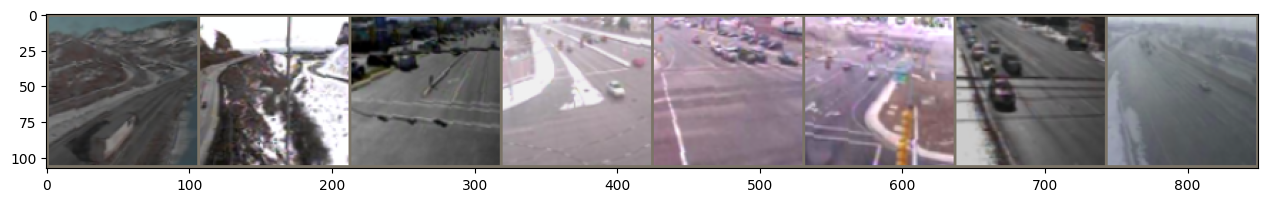

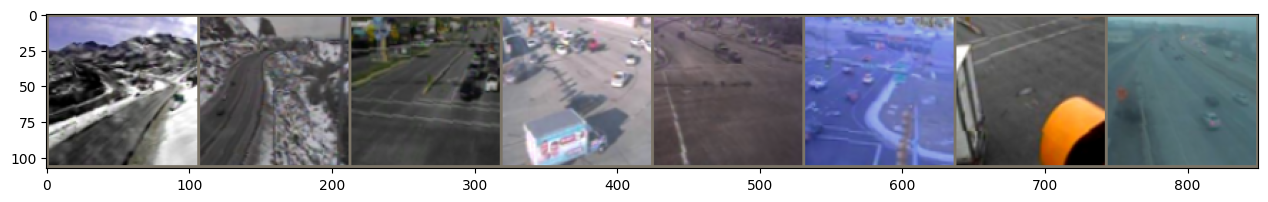

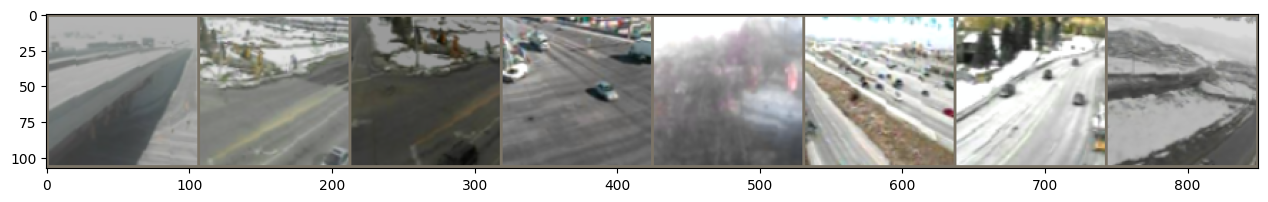

In [29]:
def imshow(inp, title=None):
    #Imshow for Tensor
    inp = inp.cpu().detach().numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)


dl_viz = {phase : torch.utils.data.DataLoader(ds[phase], shuffle = True, batch_size=8, num_workers=0)\
              for phase in ['train', 'val']}


imga, imgb, imgc, namea, nameb, namec  = next(iter(dl_viz['train']))


print(namea, nameb, namec)

outa = utils.make_grid(imga)
outb = utils.make_grid(imgb)
outc = utils.make_grid(imgc)


plt.figure(figsize = (20,2))
imshow(outa)
plt.figure(figsize = (20,2))
imshow(outb)
plt.figure(figsize = (20,2))
imshow(outc)


**Q4** Instancier un modèle ResNet50 (utiliser torchvision.models.resnet50) pré-entraîné sur le jeu imagenet. Modifier la dernière couche du réseau pour une tâche de réapprentissage (on travaillera dans un espace de sortie de dimension 10).

In [30]:
import torchvision

nclasses = 10
model = models.resnet50(pretrained = True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, nclasses)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


**Q5** Compléter la boucle d'apprentissage et vérifier son bon fonctionnement sur une époque.

In [31]:
class TripletLoss(nn.Module):
    def __init__(self, margin=1.):
        super(TripletLoss, self).__init__()
        self.margin = margin

    def calc_euclidean(self, x1, x2):
        return (x1 - x2).pow(2).sum(1)

    def forward(self, anchor: torch.Tensor, positive: torch.Tensor, negative: torch.Tensor) -> torch.Tensor:
        distance_positive = self.calc_euclidean(anchor, positive)
        distance_negative = self.calc_euclidean(anchor, negative)
        losses = torch.relu(distance_positive - distance_negative + self.margin)

        return losses.mean()

In [32]:
num_epochs = 1

dl = {phase : torch.utils.data.DataLoader(ds[phase], shuffle = True, batch_size=16, num_workers=0)\
              for phase in ['train','val']}
import torch
import copy

model = model.cuda()
optimizer = torch.optim.Adam(model.parameters(),lr = 0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size = 50, gamma = 0.2)
tripletloss = TripletLoss()

In [33]:
since = time.time()
best_model_wts = copy.deepcopy(model.state_dict())
best_acc = 0.0
train_losses=[]
val_losses=[]
val_accs = []

for epoch in range(num_epochs):
    print('Epoch {}/{}'.format(epoch, num_epochs - 1))
    print('-' * 10)

    for phase in ['train', 'val']:
        if phase == 'train':
            model.train()
        else:
            model.eval()

        running_loss = 0.0
        running_corrects = 0
        # Iterate over data.

        for imga, imgb, imgc, _, _, _ in dl[phase]:


            optimizer.zero_grad()


            with torch.set_grad_enabled(phase == 'train'):

              outputa = model(imga)
              outputb = model(imgb)
              outputc = model(imgc)

              loss = tripletloss(outputa, outputb, outputc)

              if phase == 'train':
                loss.backward()
                optimizer.step()



            running_loss += loss.item() *  imga.size(0)
            #del
            del imga, imgb, imgc
            del outputa, outputb, outputc
            del loss
            torch.cuda.empty_cache()



        epoch_loss = running_loss / len(ds[phase])


        print('{} Loss: {:.4f}'.format(
            phase, epoch_loss))



        if phase == 'train':
            train_losses.append(epoch_loss)
        elif phase == 'val':
            val_losses.append(epoch_loss)




Epoch 0/0
----------


IndexError: index 5000 is out of bounds for dimension 0 with size 5000

**Q6** Charger les poids d'un modèle entraîné sur 50 époques ('data/reid_resnet50_60ep.pt').

In [ ]:
best_model_wts = torch.load('data/reid_resnet50_60ep.pt')
model.load_state_dict(best_model_wts)


**Q7** Présenter des cas de réussite et d'échec sur le jeu de test:
- deux images qui sont difficiles à attribuer (à l'oeil) à la même scènes et pour lesquelles le modèle prédit deux points relativement proches dans l'espace latent.
- deux images faciles à attribuer à des scènes différentes et qui sont considérées comme issues de la même caméra par le modèle.
On s'appuiera sur les bouts de code suivants:

In [ ]:
ds['test'] = DS_singleton_flat(ds_tensor['test'], tr['test'])
dl['test'] = torch.utils.data.DataLoader(ds['test'], shuffle = False, batch_size=10, num_workers=0)

In [ ]:
from numpy.ma.core import ids
model.eval()
outputs = []
idxs = []
for img, idx in dl['test']:
            img = img.cuda()
            with torch.set_grad_enabled(False):
                output = model(img)
            outputs.append(output.cpu())
            del img, output
            torch.cuda.empty_cache()
            idxs += list(idx)
outputs = torch.cat(outputs, dim=0)
outputs = outputs.numpy()

In [ ]:
from scipy.spatial import distance_matrix

dist = distance_matrix(outputs, outputs)
from matplotlib.pyplot import imshow
plt.figure(2)
t = 1.1
#Visualisation de la matrice des distances entre N et N+v:
N = 900
v = 100
imshow((dist)[N:N+v,N:N+v], vmin=0, vmax=1, cmap='jet')
plt.colorbar()

In [ ]:
# Visualisation d'une partie des images (ici, les images d'indices 860 à 870)
def imshow(inp, title=None):
    #Imshow for Tensor
    inp = inp.cpu().detach().numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)


end_ds =  torch.utils.data.Subset(ds['test'], range(860,870))
dl_viz = torch.utils.data.DataLoader(end_ds, shuffle = False, batch_size=5, num_workers=0)\

imga, namea  = next(iter(dl_viz))
imgz = imga.cpu()
print(namea)
#% Make a grid from batch
outa = utils.make_grid(imga)
plt.figure(figsize = (20,2))
imshow(outa)
